In [1]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Load the Data
# ------------------------------------------------------------------------------
# CRITICAL: Use the 'augmented' file we fixed. Do not use the raw original file.
file_path = 'north_india_crops_augmented.csv'

try:
    df = pd.read_csv(file_path)
    print(f"✅ Data Loaded. Shape: {df.shape}")
except FileNotFoundError:
    print(f"❌ CRITICAL ERROR: '{file_path}' not found. Please run the data repair script first.")
    # Stop execution if file is missing
    raise

# 2. Separate Features and Target
# ------------------------------------------------------------------------------
X = df[['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']]
y = df['label']

# 3. Label Encoding (Target to Numbers)
# ------------------------------------------------------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"✅ Classes Encoded. Total unique crops: {len(le.classes_)}")

# 4. Stratified Split (80% Train / 20% Test)
# ------------------------------------------------------------------------------
# Stratify ensures that if we have 200 Almonds, 160 go to Train and 40 to Test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 5. Scaling (MANDATORY for KNN)
# ------------------------------------------------------------------------------
# KNN computes distances. If N is 100 and pH is 6, the distance is dominated by N.
# Scaling makes all features contribute equally.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data Preprocessing Complete.")
print(f"   Training Samples: {X_train.shape[0]}")
print(f"   Testing Samples:  {X_test.shape[0]}")

✅ Data Loaded. Shape: (30530, 8)
✅ Classes Encoded. Total unique crops: 80
✅ Data Preprocessing Complete.
   Training Samples: 24424
   Testing Samples:  6106


In [2]:
# 6. Define the Models
# ------------------------------------------------------------------------------

# Model A: Random Forest (The Generalist)
# - n_estimators=300: High number of trees for stability.
# - max_depth=15: Limits tree growth to prevent memorizing the data (Overfitting).
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

# Model B: K-Nearest Neighbors (The Specialist)
# - weights='distance': Closer neighbors have a stronger vote.
# - n_neighbors=10: Looks at the 10 closest examples.
knn_model = KNeighborsClassifier(
    n_neighbors=10,
    weights='distance',
    n_jobs=-1
)

# 7. Create the Voting Ensemble
# ------------------------------------------------------------------------------
# 'soft' voting means we average the probabilities (Confidence scores), not just the hard labels.
voting_clf = VotingClassifier(
    estimators=[('rf', rf_model), ('knn', knn_model)],
    voting='soft'
)

# 8. Train
# ------------------------------------------------------------------------------
print("⏳ Training Ensemble Model (RF + KNN)... Please wait.")
voting_clf.fit(X_train_scaled, y_train)
print("✅ Training Complete.")

# 9. Evaluate on Test Set
# ------------------------------------------------------------------------------
print("\n📊 Evaluating Model Performance...")
y_pred = voting_clf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print(f"\n🏆 Final Test Accuracy: {acc*100:.2f}%")
print("-" * 60)
# Print Detailed Report (Precision, Recall, F1-Score)
# This shows you exactly which crops are performing well and which are failing.
print(classification_report(y_test, y_pred, target_names=le.classes_))

⏳ Training Ensemble Model (RF + KNN)... Please wait.
✅ Training Complete.

📊 Evaluating Model Performance...

🏆 Final Test Accuracy: 90.68%
------------------------------------------------------------
              precision    recall  f1-score   support

      almond       0.81      0.85      0.83        40
       apple       1.00      0.42      0.60        40
     apricot       0.91      0.97      0.94        40
   asparagus       0.91      0.97      0.94        40
      banana       0.99      1.00      1.00       147
      barley       0.97      0.86      0.91       101
    beetroot       0.84      0.90      0.87        40
 bell_pepper       0.84      0.90      0.87        40
 bittergourd       1.00      1.00      1.00        40
  black_gram       0.99      0.96      0.98       102
  blackberry       0.80      0.93      0.86        40
   blueberry       1.00      0.97      0.99        40
 bottlegourd       0.95      1.00      0.98        40
    broccoli       0.75      0.95      0.8

In [3]:
# 10. Save the Artifacts
# ------------------------------------------------------------------------------
# You MUST save the scaler and encoder along with the model.
# Without the scaler, your website will feed raw numbers to the model, and it will fail.

joblib.dump(voting_clf, 'crop_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'label_encoder.pkl')

print("💾 Success! Saved 'crop_model.pkl', 'scaler.pkl', and 'label_encoder.pkl'.")

# ------------------------------------------------------------------------------
# 11. DEMO: How to use this in your App/Website
# ------------------------------------------------------------------------------
def predict_crop(N, P, K, temp, humidity, ph, rain):
    # A. Load Artifacts (In your actual app, load these once at startup)
    model = joblib.load('crop_model.pkl')
    sc = joblib.load('scaler.pkl')
    enc = joblib.load('label_encoder.pkl')

    # B. Prepare Input
    # Input MUST be a 2D array: [[N, P, K, ...]]
    input_data = np.array([[N, P, K, temp, humidity, ph, rain]])

    # C. Scale Input (CRITICAL STEP)
    # Apply the same math used during training
    input_scaled = sc.transform(input_data)

    # D. Predict
    prediction_prob = model.predict_proba(input_scaled) # Get probabilities
    prediction_idx = np.argmax(prediction_prob)         # Get highest prob index
    predicted_label = enc.inverse_transform([prediction_idx])[0] # Convert index to text

    confidence = prediction_prob[0][prediction_idx] * 100

    return predicted_label, confidence

# Test with a dummy example (e.g., specific conditions for Rice)
# Rice generally needs: N=80, P=40, K=40, Temp=25, Hum=80, pH=7, Rain=200
pred_crop, conf = predict_crop(80, 40, 40, 25, 80, 7.0, 200)

print(f"\n🧪 Test Prediction:")
print(f"   Input: N=80, P=40, K=40, Temp=25, Hum=80, pH=7, Rain=200")
print(f"   Result: {pred_crop} ({conf:.2f}% confidence)")

💾 Success! Saved 'crop_model.pkl', 'scaler.pkl', and 'label_encoder.pkl'.

🧪 Test Prediction:
   Input: N=80, P=40, K=40, Temp=25, Hum=80, pH=7, Rain=200
   Result: jute (63.18% confidence)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


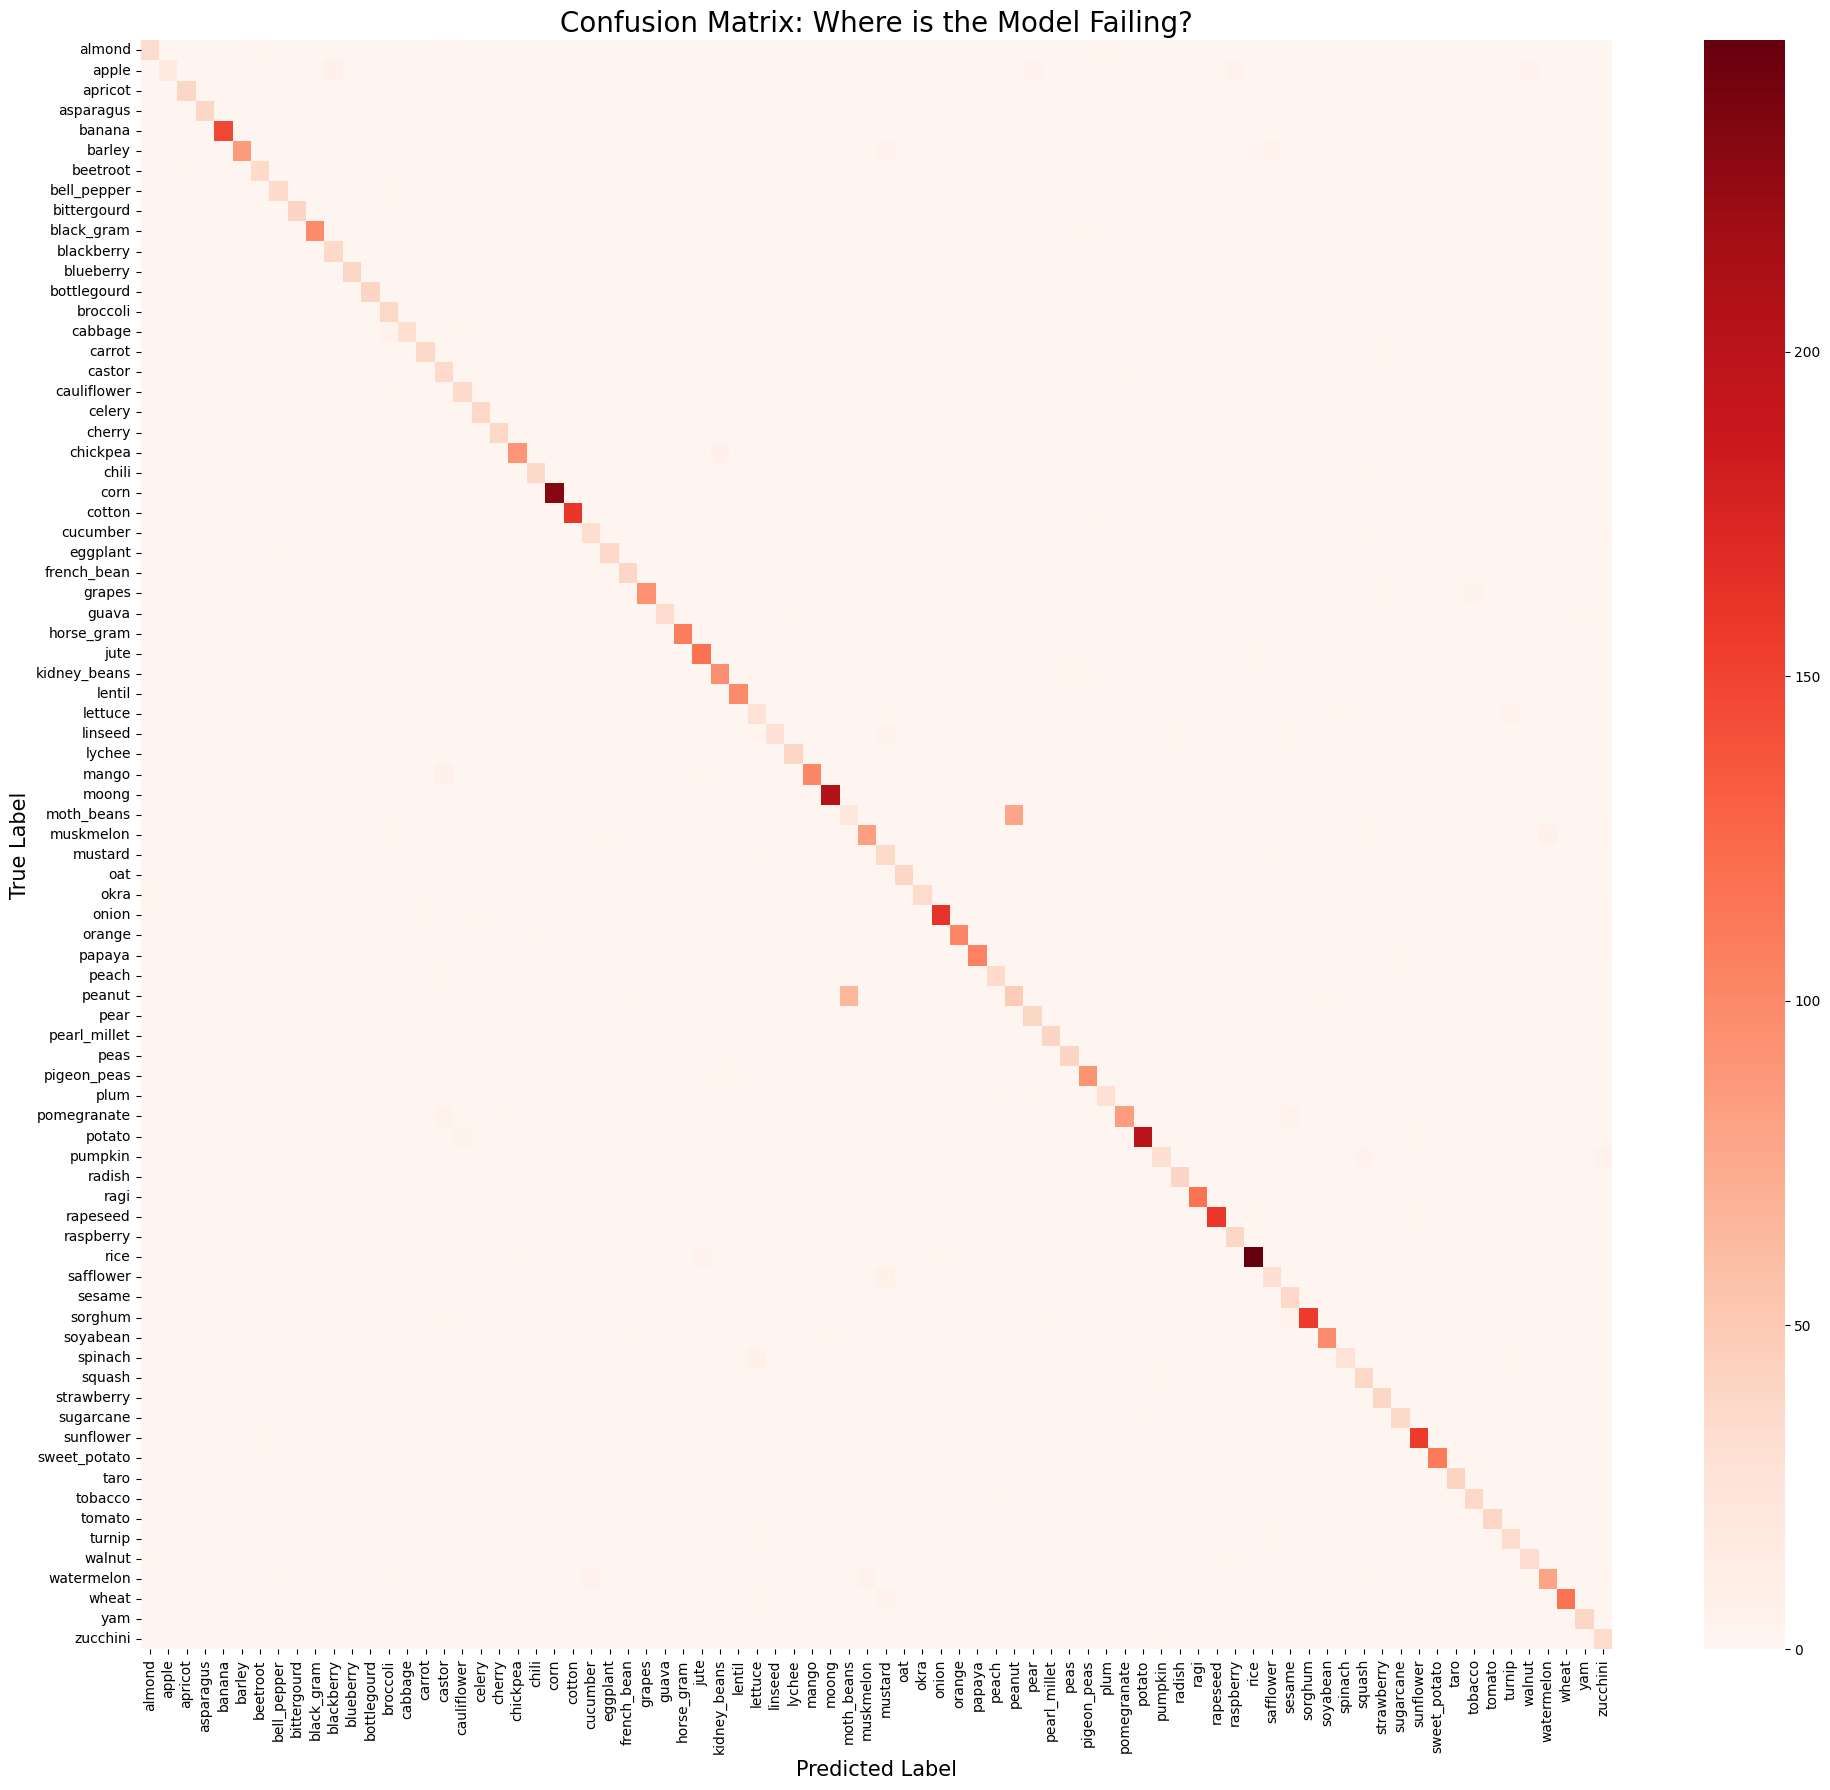

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Generate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# 2. Plotting
plt.figure(figsize=(20, 18)) # Large size for 80 classes
sns.heatmap(cm, annot=False, cmap='Reds', fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.title('Confusion Matrix: Where is the Model Failing?', fontsize=20)
plt.xlabel('Predicted Label', fontsize=15)
plt.ylabel('True Label', fontsize=15)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipython-input-61440179.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')


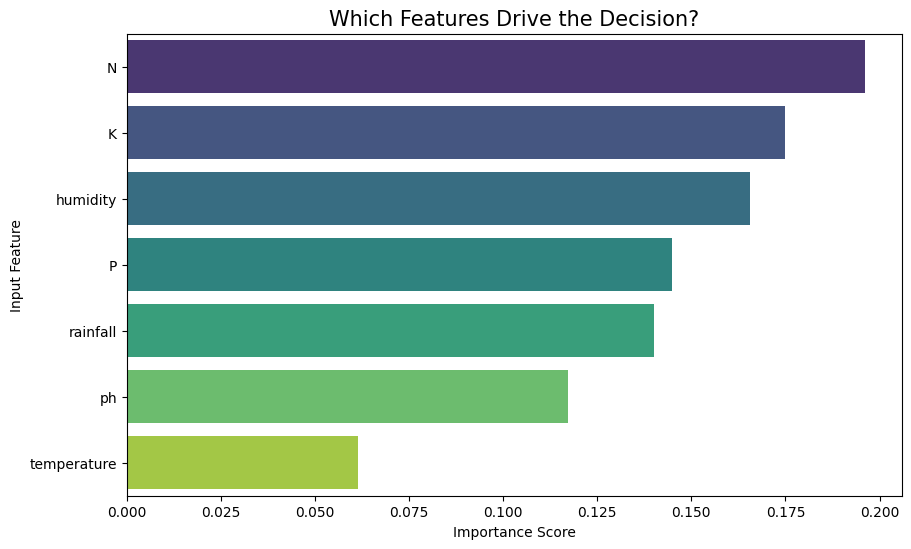

Interpretation:
The most critical factor for crop prediction is: N


In [5]:
# Extract the Random Forest model from the Ensemble
# We named it 'rf' in the VotingClassifier list
rf_inner = voting_clf.named_estimators_['rf']

# Get importances
importances = rf_inner.feature_importances_
feature_names = X.columns

# Create a DataFrame for plotting
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_df, palette='viridis')
plt.title('Which Features Drive the Decision?', fontsize=15)
plt.xlabel('Importance Score')
plt.ylabel('Input Feature')
plt.show()

print("Interpretation:")
print(f"The most critical factor for crop prediction is: {feature_df.iloc[0]['Feature']}")